In [1]:
%matplotlib inline 

import cv2
import numpy as np
import csv

from math import ceil, floor, gcd, log10, log
from typing import List, TextIO, Tuple
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation

In [2]:
def skip_header(f: TextIO, skip_to_angles: int = 3) -> Tuple[int, int]:
    """Skip over the ies header and returns number of vertical and horizontal angles."""
    """    
    for line in f:
        if "TILT" in line : 
            f.readline()
            break

    line = f.readline()

    """    
    for _ in range(4):
        line = f.readline()
    
    angles = line.split(' ')
    angles_v, angles_h = int(angles[0]), int(angles[1])
    for _ in range(skip_to_angles):
        line = f.readline()
    return angles_v, angles_h

def save_to_csv(path: str):
    data = []
    angles_rows = []
    angles_cols = []
    
    with open(path, 'r') as f:
        angles_v, angles_h = skip_header(f)

        angles_cols = parse_angles(f, angles_v)
        angles_cols = ["XXX"] + angles_cols
        
        angles_rows = parse_angles(f, angles_h)
        
        dataRaw = parse_angles(f, angles_v * angles_h)

        for i in range(angles_h):
            data += [[angles_rows[i]] + dataRaw[i * angles_v : i * angles_v + angles_v]]

    with open('data.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        
        # write row
        writer.writerow(angles_cols)

        # write multiple rows
        writer.writerows(data)
        
def save_to_csv_01(path: str):
    data = []
    angles_rows = []
    angles_cols = []
    
    with open(path, 'r') as f:
        angles_v, angles_h = skip_header(f)

        angles_cols = parse_angles(f, angles_v)        
        angles_rows = parse_angles(f, angles_h)
        
        angles_cols = interpolation.zoom(angles_cols, 2)
        angles_cols = np.round(angles_cols, 1)
        angles_cols = angles_cols.tolist()

        angles_rows = interpolation.zoom(angles_rows, 2)
        angles_rows = np.round(angles_rows, 1)
        angles_rows = angles_rows.tolist()

        dataRaw = parse_angles(f, angles_v * angles_h)
        dataRaw = np.array(dataRaw)
        dataRaw = dataRaw.reshape(angles_h, angles_v)
        dataRaw = interpolation.zoom(dataRaw, 2)
        dataRaw = np.reshape(dataRaw, -1)
        dataRaw = dataRaw.tolist()

        for i in range(len(angles_rows)):
            data += [[angles_rows[i]] + dataRaw[i * len(angles_cols) : i * len(angles_cols) + len(angles_cols)]]

    with open('data.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        
        # write row
        angles_cols = [0] + angles_cols
        writer.writerow(angles_cols)

        # write multiple rows
        writer.writerows(data)

        
def parse_angles(f: TextIO, angles: int) -> List[float]:
    """Parses angle part of ies and returns angle values.

    Args:
        f (TextIO): Opened IES file.
        angles (int): Number of angles to be read.

    Returns:
        List[float]: List of angle values.
    """
    line = f.readline()
    values = [float(value) for value in line.split(' ')]
    while len(values) < angles:
        line = f.readline()
        values += [float(value) for value in line.split(' ')]
    return values


def load_ies(path: str, skip_to_angles: int = 3) -> np.ndarray:
    """Loads ies into array.

    Args:
        path (str): Path to the ies file.
        skip_to_angles (int, optional): How many lines are going to be skipped to angles. Defaults to 3.

    Returns:
        np.ndarray: 2D array containing ies data. 
    """
    with open(path, 'r') as f:
        angles_v, angles_h = skip_header(f, skip_to_angles)
        data = np.zeros(angles_h * angles_v, dtype=np.float32)
        values = parse_angles(f, angles_v)
        values = parse_angles(f, angles_h)

        i = 0
        line = f.readline()
        while line:
            values = [float(value) for value in line.split(' ')]
            data[i:i+len(values)] = values
            i += len(values)
            line = f.readline()
        data = data.reshape(angles_h, angles_v).T
        #data = np.flipud(data)
        return data

    
def locate_angle_center(path: str, skip_to_angles: int = 3) -> np.ndarray:
    """Locate the center (0, 0) in ies file and returns it's indices.

    Args:
        path (str): Path to the ies file.
        skip_to_angles (int, optional): How many lines are going to be skipped to angles. Defaults to 3.

    Returns:
        np.ndarray: (y, x) coordinates of the (0, 0) center.
    """
    with open(path, 'r') as f:
        angles_v, angles_h = skip_header(f, skip_to_angles)

        values = parse_angles(f, angles_v)
        center_v_index = values.index(0)

        values = parse_angles(f, angles_h)
        center_h_index = values.index(0)
        return np.array([center_v_index, center_h_index])
        #return np.array([angles_v - 1 - center_v_index, angles_h - 1 - center_h_index])


def computeMaxGFromColumn(ies, column):
    height = int(ies.shape[0])
    maxG = -1.0
    maxGRow = -1
    
    for y in range(0, height - 1):
        valueUp = ies[y, column]
        valueDown = ies[y + 1, column]
        
        #gradient = log10(valueDown) - log10(valueUp)
        gradient = log10(valueUp) - log10(valueDown)
        
        if (gradient > maxG):
            maxG = gradient
            maxGRow = y

    return maxG, maxGRow

In [3]:
fileName = "C519-LB_RIGHT.ies" # VW270-LB-LEFT.ies

ies = load_ies(fileName)

centerY, centerX = locate_angle_center(fileName)
ies_debug = ies.copy()

for y in range(-3, 3):
    for x in range(-3, 3):
        ies_debug[centerY + y][centerX + x] = 100000;

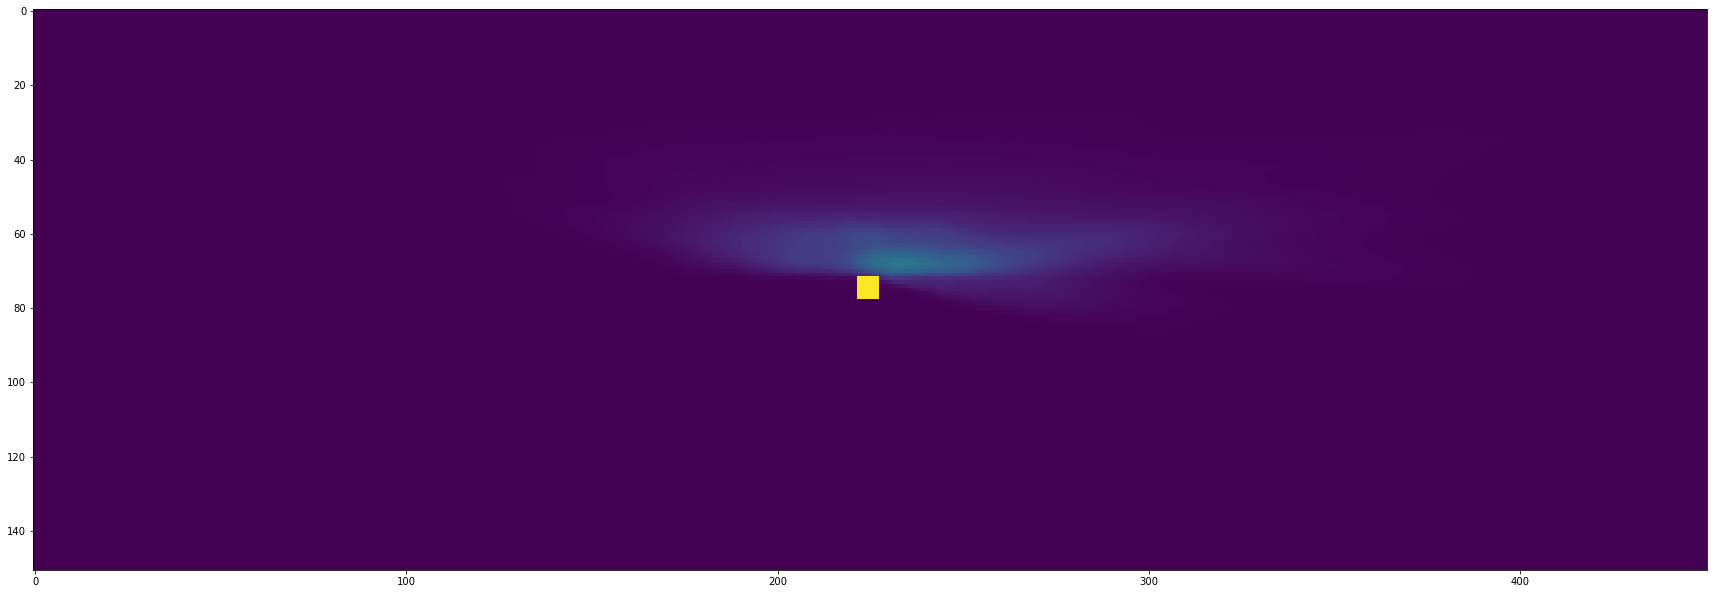

In [4]:
plt.figure(figsize=(30, 30))
plt.imshow(ies_debug, interpolation='nearest')
plt.show()

In [5]:
# csv
save_to_csv(fileName)
#save_to_csv_01(fileName)

In [6]:
# resize (bilinear) - final step 0.1
width = int(ies.shape[1] * 2)
height = int(ies.shape[0] * 2)
dim = (width, height)

# not bilinear!
# for computation - interpolation via spline (smooth curve)
# error <0.05 is fine

print("Center: ", centerY, centerX)
print("Center point: ", ies[int(centerY)][int(centerX)])
print("IES: ", ies.shape)

# Original - OpenCV version
#ies = cv2.resize(ies, dim, interpolation = cv2.INTER_LINEAR)
ies = interpolation.zoom(ies, 2)

# center position multiplied by 2 because of the resize above
centerY = centerY * 2
centerX = centerX * 2

print("Center point after zoom: ", ies[int(centerY)][int(centerX)])

stepSize = 0.1 #0.2 original, 0.1 after intetrpolation

columns = [4.0, 3.0, 2.0, 1.0, 0.0, -1.0, -2.0, -3.0, -4.0]
columnsInIES = [centerX - int(e / 0.1) for e in columns]

for x in columnsInIES:
    maxG, maxGRow = computeMaxGFromColumn(ies, x)
    maxGRow = ((maxGRow-centerY))*0.1
    print(maxG,"\t", maxGRow);

Center:  75 225
Center point:  516.2
IES:  (151, 451)
Center point after zoom:  558.31775
0.254751321352956 	 -0.5
0.26742254823294864 	 -0.5
0.2756363562021633 	 -0.5
0.33547739440798585 	 -0.6000000000000001
0.2571566436822157 	 -0.6000000000000001
0.2639401919036022 	 -0.4
0.36949708168844486 	 0.0
0.2242568425802216 	 0.2
0.2113326441258696 	 0.7000000000000001


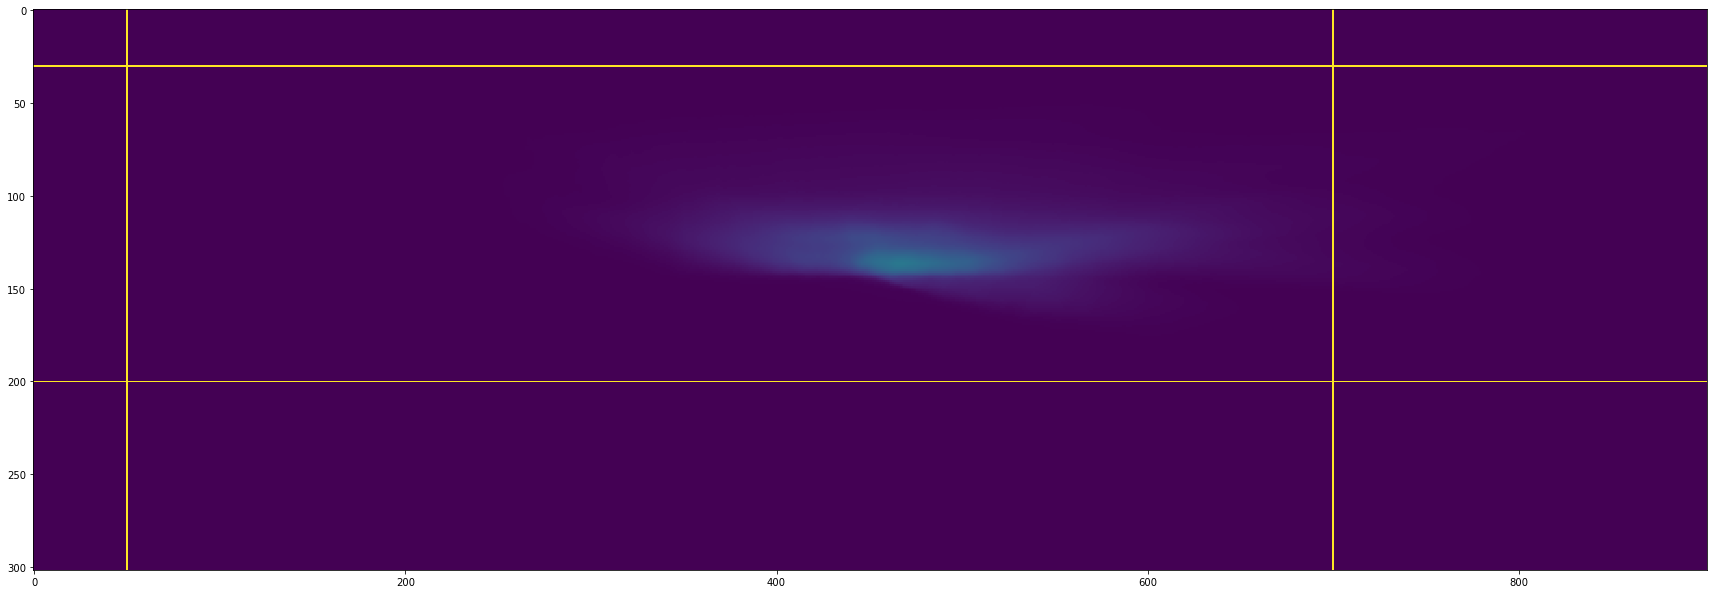

In [7]:
# colors for debug purposes
anglesColumns = [-25.0, 40.0]
angleToColumn = [centerX - int(e / 0.1) for e in anglesColumns]

for x in angleToColumn:
    for y in range(0, height):
        ies[y][x] = 100000;

anglesRows = [12.0, -5.0]
angleToRows = [centerY - int(e / 0.1) for e in anglesRows]        

for y in angleToRows:
    for x in range(0, width):
        ies[y][x] = 100000;

plt.figure(figsize=(30, 30))
plt.imshow(ies, interpolation='nearest')
plt.show()